## Ch06. 게이트가 추가된 RNN

5장에서 본 RNN은 순환 경로를 포함하며 과거의 정보를 기억할 수 있었다. 구조가 단순하여 구현이 쉬웠었다. 하지만 안타깝게도 성능이 좋지 못했다. 그 원인은 시계열 데이터에서 시간적으로 멀리 떨어진, 장기(long term)의존 관계를 잘 학습할 수 없기 때문이다.

위의 문제점을 해결하고자 게이트가 추가된 모델이 등장

- LSTM (Ch06)
- GRU

## 6.1 RNN의 문제점

시계열 데이터의 장기 의존 관계를 학습하기 어렵다. 그 원인은 **BPTT**에서 기울기 소실 혹은 기울기 폭발이 일어나기 때문이다. 

## 6.1.1 RNN 복습

**[그림 6-1] RNN 계층의 순환 구조 펼치기 전/후**

<img src="https://github.com/DeepHaeJoong/DeepLearningFromScratch_II/blob/master/PNG/Figure%205-8.PNG?raw=true" width="800">

$\mathbf{x}_{t}$를 입력하면 $\mathbf{h}_{t}$를 출력, 이 $\mathbf{h}_{t}$는 RNN 계층의 **은닉 상태**라고 하고, 과거 정보를 저장한다.  
이때 RNN 계층이 수행하는 처리를 계산 그래프로 나타내면 **[그림 6-2]**처럼 됩니다.

**[그림 6-2] RNN 계층의 계산 그래프(MatMul 노드는 행렬 곱을 나타냄)**

<img src="https://github.com/DeepHaeJoong/DeepLearningFromScratch_II/blob/master/PNG/Figure%205-19.PNG?raw=true" width="400">

이상이 앞 장에서 본 RNN 계층이다. 이어서 이 RNN 계층이 안고 있는 문제, 즉 장기 기억에 취약하다는 문제를 살펴보자.

## 6.1.2 기울기 소실 또는 기울기 폭발

언어 모델은 주어진 단어들을 기초로 다음에 출현할 단어를 예측하는 일을 한다. 앞 장에서는 RNN을 사용해 언어 모델을 구현했었다.(RNNLM). 이번 절에서는 RNNLM의 단점을 확인하는 차원에서 **[그림 6-3]**의 문제를 다시 한번 생각해보자.

**[그림 6-3]** "?"에 들어갈 단어는 무엇일까? (긴 맥락이 필요한 문제의 예)

<img src="https://github.com/DeepHaeJoong/DeepLearningFromScratch_II/blob/master/PNG/Figure%205-4.PNG?raw=true" width="800">

위에서 **` "?"`**에 들어가는 단어는 "Tom"이다. RNNLM이 이 문제에 올바르게 답하려면, 현재 맥락에서 "Tom이 방에서 Tv를 보고 있음"과 "그 방에 Mary가 들어옴"이란 정보를 기억해야 한다. 다시 말해 이런 정보를 RNN 계층의 은닉 상태에 인코딩해 보관해둬야 한다.

**[그림 6-4]** 정답 레이블이 "Tom"임을 학습할 때의 기울기 흐름

<img src="https://github.com/DeepHaeJoong/DeepLearningFromScratch_II/blob/master/PNG/Figure%206-4.PNG?raw=true" width="600">
위 그림과 같이 정답 레이블이 "Tom"임을 학습할 때 중요한 것이 바로 RNN계층의 존재이다. 붉은색 전파하는 부분의 기울기는 RNN 계층이 과거 방향으로 "의미 있는 기울기"를 전달함으로써 시간 방향의 의존 관계를 학습할 수 있는 것이다. 이때 기울기는 (원래대로라면) 학습해야 할 의미가 있는 정보가 들어 있고, 그것을 과거로 전달함으로써 장기 의존 관계를 학습한다. 하지만 만약 이 기울기가 중간에 사그라들면(거의 아무런 정보도 남지 않게 되면) 가중치 매개변수는 전혀 갱신되지 않게 된다. 즉, 장기 의존 관계를 학습할 수 없게 된다. 안타깝지만, 현재의 단순한 RNN 계층에서는 시간을 거슬려 올라갈수록 기울기가 작아지거나(기울기 소실) 혹은 커질 수 있으며(기울기 폭발). 대부분 둘 중 하나의 운명을 걷게 된다.

## 6.1.3 기울기 소실과 기울기 폭발의 원인

기울기 폭발의 원인을 살펴보자.

앞의 문제에 대립하면 **"T"**번째 정답 레이블이 **"Tom"**인 경우에 해당한다.이때 시간 방향 기울기에 주목하면 역전파로 전해지는 기울기 는 차례로 다음과 같다.

**tanh** $\rightarrow$ **+** $\rightarrow$ **"MatMul(행렬 곱)"** 연산을 통과한다는 것을 알 수 있다.

- **+** : 역전파는 상류에서 전해지는 기울기를 그대로 통과(기울기 변화 X)
- **tanh** : 기울기 변화(O)
- **"MatMul(행렬 곱)"** : 기울기 변화(O)

기울기 변화가 있는 **tanh** 와 **"MatMul(행렬 곱)"**항목이 왜 변화하는지 알아보자.

**[그림 6-6]** $y = \text{tanh}(x)$의 그래프(아래는 미분)

<img src="https://mlnotebook.github.io/img/transferFunctions/tanh.png" width="400">
<img src="https://mlnotebook.github.io/img/transferFunctions/dtanh.png" width="400">

아래 미분 그래프를 자세히 살펴보면, 0을 제외한 모든 값이 1.0 이하이고, $x$가 0으로부터 멀어질수록 작아진다. 즉, 역전파에서는 기울기가 **tanh** 노드를 지날때 마다 값은 계속 작아진다는 뜻이다. 그래서 **tanh** 함수를 $T$번 통과하면 기울기도 $T$번 반복해서 작아지게 된다.

> **NOTE**  
> RNN 계층의 활성화 함수로는 주로 **tanh** 함수를 사용하는데, 이를 **ReLU (max(0,x))**로 바꾸면 기울기 소실을 줄일 수 있다. 그 이유는 **ReLU**는 입력 $x$가 0이상이면, 역전파 시 상류의 기울기를 그대로 하류에 흘려보내기 때문이다. 즉, 기울기가 작아지지 않느다. 실제로 다른 논문에서도 **ReLU**를 사용하여 성능을 개선한 사례가 있다.

**[그림 6-7]** RNN 계층의 행렬 곱에만 주목했을 때의 역전파의 기울기

<img src="https://github.com/DeepHaeJoong/DeepLearningFromScratch_II/blob/master/PNG/Figure%206-7.PNG?raw=true" width="800">

**[그림 6-7]**은 상류로부터 **dh**라는 기울기가 흘러온다고 가정한다. 이때 **MatMul** 노드에서의 역전파는 **dh$\mathbf{W}^{T}_{h}$**라는 행렬 곱으로 기울기를 계산한다. 그리고 같은 계산을 시계열 데이터의 시간 크기만큼 반복한다. 여기에서 주목할 점은 이 행렬 곱셈에서는 매번 족같은 가중치인 $\mathbf{W}_{h}$가 사용된다는 것이다.

그러면 역전파 시 기울기는 **MatMul** 노드를 지날 때마다 어떻게 변하게 될까요? 직접 실험해보는 게 최고! 아래 코드를 실행해 기울기의 크기 변화를 관찰해보자.

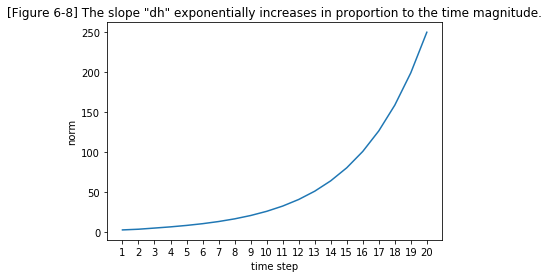

In [23]:
import numpy as np
import matplotlib.pyplot as plt

N = 2 # 미니배치 크기
H = 3 # 은닉 상태 벡터의 차원 수
T = 20 # 시계열 데이터의 길이

dh = np.ones((N, H)) 
np.random.seed(3)  # 재현할 수 있도록 난수의 시드 고정
Wh = np.random.randn(H, H)

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)
    
    
plt.plot(range(1, T+1), norm_list,)
plt.xticks(range(1, T+1))
plt.xlabel('time step')
plt.ylabel('norm')
plt.title('[Figure 6-8] The slope "dh" exponentially increases in proportion to the time magnitude.')
plt.show()

위 그림을 보면 기울기의 크기는 시간에 비례해 지수적으로 증가함을 알 수 있었다. 이것이 **기울기 폭발**이다. 이러한 기울기 폭발이 일어나면 결국 오버플로를 일으켜 **NaN**같은 값을 발생시킨다. 따라서 신경망 학습을 제대로 수해할 수 없게 된다.

그러면 **Wh**의 초깃값을 다음과 같이 변경한 후 두 번째 실험을 해보자.

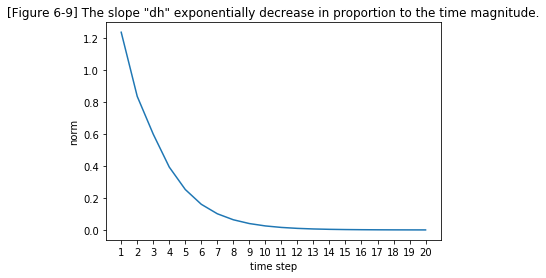

In [24]:
import numpy as np
import matplotlib.pyplot as plt

N = 2 # 미니배치 크기
H = 3 # 은닉 상태 벡터의 차원 수
T = 20 # 시계열 데이터의 길이

dh = np.ones((N, H)) 
np.random.seed(3)  # 재현할 수 있도록 난수의 시드 고정
# Wh = np.random.randn(H, H) # 변경 전
Wh = np.random.randn(H, H) * 0.5 # 변경 후

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)
    
    
plt.plot(range(1, T+1), norm_list,)
plt.xticks(range(1, T+1))
plt.xlabel('time step')
plt.ylabel('norm')
plt.title('[Figure 6-9] The slope "dh" exponentially decrease in proportion to the time magnitude.')
plt.show()

위 그림을 보면, 이번에는 기울기가 지수적으로 감소함을 확인할 수 있다. 이것이 **기울기 소실(vanishing gradient)**이다. 기울기 소실이 일어나면 기울기가 매우 빠르게 작아진다. 그리고 기울기가 일정 수준 이하로 작아지면 가중치 매개변수가 더 이상 갱신되지 않으므로, 장기 의존 관계를 학습할 수 없게 된다.

지금까지의 실험에서 기울기의 크기는 지수적으로 증가하거나 감소했었다. 왜 이런 지수적 변화가 일어날까?  
물론 행렬 **Wh**를 **T**번 반복해서 **"곱"**했기 때문이다. 만약 **Wh**가 스칼라면 이야기는 단순해지는데, **Wh**가 1보다 크면 지수적으로 증가하고, 1보다 작으면 지수적으로 감소한다.

그럼 **Wh**가 스칼라가 아니라 행렬이라면 어떨까?

행렬의 **"특잇값"**이 척도가 된다. 행렬의 특잇값이란? 단단히 말해서 데이터가 얼마나 펴져 있는 정보를 나타낸다. 이 특잇값의 값(더 정확하게는 여러 특잇값 중 최댓값)이 1보다 큰지 여부를 보면 기울기가 어떻게 변할지 예측할 수 있다.

### 6.1.4 기울기 폭발 대책

**6.1.3**에서 문제가 되는 기울기 폭발과 기울기 소실을 살펴왔었다. 그럼 계속해서, 그 해결책을 알아보자.

**기울기 폭발**

- 전통적인 기법 : 기울기 클리핑 **gradients clipping** 기법(알고리즘 의사 코드에 사용)

$$
\text{if  } || \hat{x} || \geq thresholds:  
$$

$$
\hat{g} = \frac{thresholds}{|| \hat{g} || }\hat{g}
$$

- 위의 전통적인 기법을 코드로 구현해보자.

In [7]:
import numpy as np

dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10

grads = [dW1, dW2]

In [9]:
max_norm = 5.0

def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad**2)
    total_norm = np.sqrt(total_norm)
    
    rate = max_norm / (total_norm + 1e-6)
    
    if rate < 1 :
        for grad in grads:
            grad *= rate

앞으로 자주 이용하게될 함수이므로 common/utils.py에 구현하였으니 사용

## 6.2 기울기 소실과 LSTM

RNN 학습에서는 기울기 소실도 큰 문제이다. 그리고 이 문제를 해결하려면 RNN 계층의 구조를 근본부터 뜯어고쳐야 한다. 여기서 등장하는 것이, 이번 장의 핵심 주제인 '게이트'가 추가된 RNN 입니다. 

대표적으로 게이트가 추가된 RNN 두 종류

- LStM
- GRU

이번 절에서는 LSTM에 집중하여 그 구조를 차분히 살펴보면서 LSTM이 기울기 소실을 일으키지 않는다는(혹은 일으키기 어렵게 한다는) 사실을 밝히고 있다. 

## 6.2.1 LSTM의 인터페이스

**[그림 6-10] 단순화한 도법을 적용한 RNN 계층 : 이번 절에서는 가독성을 고려하여 단순화한 도법을 사용한다.**

$$
\mathbf{h}_t = \text{tanh}(\mathbf{h}_{t-1}\mathbf{W}_{h} + \mathbf{x}_{t}\mathbf{W}_{x} + \mathbf{b})
$$

위 계산을 **tanh**라는 직사각형 노드 하나로 그림. 이 직사각형 노드 안에 행렬 곱과 편향의 합, 그리고 **tanh** 함수에 의한 변환이 모두 포함된 것이다.

**[그림 6-11] RNN 계층과 LSTM 계층 비교**

**c** 라는 경로가 존재

- **c** : 기억 셀(memory cell)이라 하며, LSTM 전용의 기억 메커니즘이다. 
- 특징 : 데이터를 자기 자신으로만(LSTM 계층 내에서만) 주고 받는다는 것이다. 즉, LSTM 계층 내에서만 완결되고, 다른 계층으로는 출력하지 않는다. 반면, LSTM의 은닉상태 h는 RNN 계층과 마찬가지로 다른 계층으로(위쪽으로) 출력된다.

> **NOTE**  
> LSTM의 출력을 받는 쪽에서 보면 LSTM의 출력은 은닉 상태 **h**뿐이다. 기억 셀 **c**는 외부에서는 보이지 않는다. 그래서 그 존재 자체를 생각할 필요가 없다고 한다.

## 6.2.2 LSTM 계층 조립하기

[Understaing LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs) 블로그 참고

**[그림 6-12] 기억 셀 $c_t$를 바탕으로 은닉 상태 $h_t$를 계산하는 LSTM 계층**

- 기억 셀 $c_t$는 시각 $t$에서의 LSTM의 기억이 저장돼 있는데, 과거로부터 시각 $t$까지에 필요한 모든 정보가 저장돼 있다고 가정(혹은 그렇게 되도록 학습을 수행), 글고 필요한 정보를 간직한 이 기억을 바탕으로 외부 계층에 은닉 상태($h_t$)를 출력한다. 이 때 출력하는 $h_t$는 아래 그림과 같이 기억 셀의 값을 tanh 함수로 변환한 값이다.

- $c_t$는 3개의 입력($c_{t-1}, h_{t-1}, x_{t}$)으로부터 "어떤 계산"을 수행하여 구할 수 있다. 핵심은 갱신된 $c_t$를 사용해 은닉 상태 $h_t$를 계산한다는 것이다. 또한 이 계산은 $h_t$ = tanh($c_t$)인데, 이는 $c_t$의 각 요소에 tanh 함수를 적용한다는 것이다.

> **NOTE**
> 기억 셀 $c_t$와 은닉 상태 $h_t$의 관계는 (여기까지의) $c_t$의 각 원소에 tanh 함수를 적용한 것일 뿐이다. 이 말이 뜻하는 바는 기억 셀 $c_t$와 은닉 상태 $h_t$의 원소 수는 같다는 것이다. 예컨대 기억 셀 $c_t$의 원소가 100개면 은닉 상태 $h_t$의 원소 수도 100개가 된다.

#### 게이트란 무엇인가?

- **데이테의 흐름을 제어함**

**[그림 6-13] 비유하자면 게이트는 물의 흐름을 제어한다.**


"열기/닫기"뿐 아니라, 어느 정도 열지를 조절할 수 있다. 다시 말해 다음 단계로 흘려보낼 물의 양을 제어한다. "어느 정도"를 "열림 상태"라 부르며, **[그림 6-14]**처럼 0.7(70%)이나 0.2(20%)처럼 제어 할 수 있다.

**[그림 6-14] 물이 흐르는 양을 0.0 ~ 1.0 범위까지 제어한다.**

**중요**
**"게이트를 얼마나 열까"라는 것도 데이터로부터 (자동으로) 학습한다는 점입니다.**

> **NOTE**  
> 게이트는 게이트의 열림 상태를 제어하기 위해서 전용 가중치 매개변수를 이용하며, 이 가중치 매개변수는 학습 데이터로부터 갱신된다. 참고로, 게이트의 열림 상태를 구할 때는 시그모이드 함수를 사용하는데, 시그모이드 함수의 출력이 마침 0.0 ~ 1.0 사이의 실수이기 때문이다.

## 6.2.3 output 게이트

### 6월 26일(토) LSTM 질문 정리

1. page 245, 행렬의 "특이값"정도라는 표현?
    - 특이값과 연결하여 어려움 존재.
    - 내 의견 : 특이값이 1보다 큰지 여부를 보면 기울기 크기가 어떻게 변할지 예측할 수 있다.? 특이값의 성질로 표현한것 같음.. 행렬의 곱을 다음과 같이 전개할 수 있음. **dh$\mathbf{W}^{T}_{h}\mathbf{W}^{T}_{h}\mathbf{W}^{T}_{h}\cdots\mathbf{W}^{T}_{h}$** 를 보면 (NxH)(HxH)(HxH)(HxH) $\cdots$ (HxH) => (NxH) 꼴